# Import package

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(100)

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

%matplotlib inline

sns.set()

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(100)
   tf.random.set_seed(100)
   np.random.seed(100)
   random.seed(100)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load file

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Kuliah/Skripsi/CPO-bappebti.csv', parse_dates=['Tanggal'])
df = df[df['Penyerahan'] == "SPOT"].reset_index(drop = True)
df = df[["Tanggal", "Harga"]]

price = df.Harga.values.reshape(-1, 1)

# Analysis

In [ ]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - (seq_len-1)): # seq_len diganti jadi (seq_len-1)
        d.append(data[index: index + seq_len])

    return np.array(d)

def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
SEQ_LEN = 11
SEQ = (8,9,10) #default
train_split = 0.7

data = to_sequences(price, SEQ_LEN)
num_train = int(train_split * data.shape[0])
train = data[:num_train, :, :]

scaler = MinMaxScaler()
scaler = scaler.fit(train.reshape(-1,1))

print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 5764.000000, Max: 10981.000000


In [ ]:
data_scaled = scaler.transform(price)
data_scaled = to_sequences(data_scaled, SEQ_LEN)
data_scaled = data_scaled[:,SEQ,:]

train_scaled = data_scaled[:num_train, :, :]
test_scaled = data_scaled[num_train:, :, :]

X_train = train_scaled[:, :-1, :]
Y_train = train_scaled[:, -1, :]
X_test = test_scaled[:, :-1, :]
Y_test = test_scaled[:, -1, :]

tanggal_train = df["Tanggal"][10:1719+10].reset_index(drop = True)
tanggal_test = df["Tanggal"][1719+10:].reset_index(drop = True)

In [ ]:
reset_random_seeds()

WINDOW_SIZE = len(SEQ) - 1

model = Sequential()
model.add(LSTM(6, return_sequences=False, 
              input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dense(1))

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='mean_squared_error', 
    optimizer=opt
)

history_data = model.fit(
    X_train, 
    Y_train, 
    epochs=200, 
    batch_size=32, 
    shuffle=False,
    verbose=0
)

y_hatTrain = model.predict(X_train)
#y_hat = model.predict(X_test)

y_train_inverse = scaler.inverse_transform(Y_train)
y_hatTrain_inverse = scaler.inverse_transform(y_hatTrain)

#y_test_inverse = scaler.inverse_transform(Y_test)
#y_hat_inverse = scaler.inverse_transform(y_hat)

MSEDataTraining = mse(y_hatTrain_inverse, y_train_inverse)
#MSEDataTesting = mse(y_hat_inverse, y_test_inverse)

print("Nilai MSE data train = {}".format(MSEDataTraining))
#print("Nilai MSE data test = {}".format(MSEDataTesting))

In [ ]:
#model.save('/content/gdrive/My Drive/Kuliah/Skripsi/modelLSTM')

# Predict

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Kuliah/Skripsi/modelLSTM')

y_hatTrain = model.predict(X_train)
y_hat = model.predict(X_test)

y_train_inverse = scaler.inverse_transform(Y_train)
y_hatTrain_inverse = scaler.inverse_transform(y_hatTrain)

y_test_inverse = scaler.inverse_transform(Y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

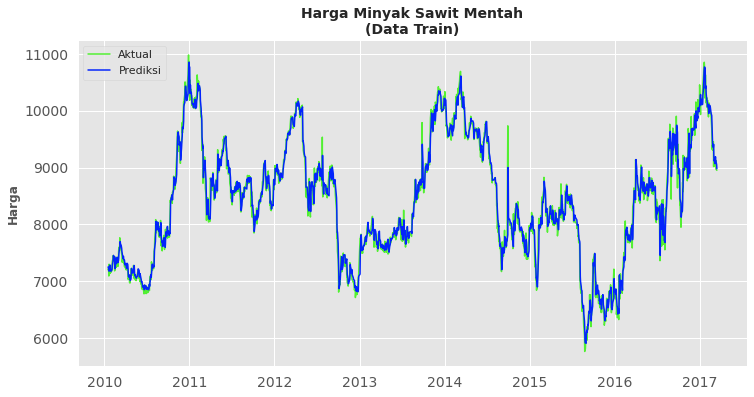

In [ ]:
y_train_inverse_df = pd.DataFrame(y_train_inverse, columns=["Aktual"]).reset_index(drop = True)
y_hatTrain_inverse_df = pd.DataFrame(y_hatTrain_inverse, columns=["Prediksi"]).reset_index(drop = True)
train_df = pd.concat([tanggal_train, y_train_inverse_df, y_hatTrain_inverse_df], axis=1)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(train_df["Tanggal"], train_df["Aktual"], color = '#52f032')
sns.lineplot(train_df["Tanggal"], train_df["Prediksi"], color = '#0324fc')

ax.set_title('Harga Minyak Sawit Mentah\n(Data Train)', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('')
ax.set_ylabel('Harga', fontsize = 12, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
ax.legend(["Aktual", "Prediksi"])

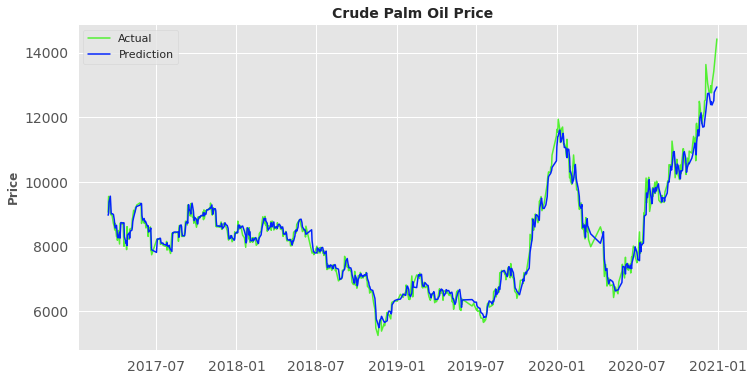

In [ ]:
y_test_inverse_df = pd.DataFrame(y_test_inverse, columns=["Aktual"]).reset_index(drop = True)
y_hat_df = pd.DataFrame(y_hat, columns=["Prediksi Normalisasi"]).reset_index(drop = True)
y_hat_inverse_df = pd.DataFrame(y_hat_inverse, columns=["Prediksi"]).reset_index(drop = True)
test_df = pd.concat([tanggal_test, y_test_inverse_df, y_hat_df, y_hat_inverse_df], axis=1)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(test_df["Tanggal"], test_df["Aktual"], color = '#52f032')
sns.lineplot(test_df["Tanggal"], test_df["Prediksi"], color = '#0324fc')

ax.set_title('Crude Palm Oil Price', fontsize = 14, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('')
ax.set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
ax.legend(["Actual", "Prediction"])

In [ ]:
MAPEDataTesting = mape(y_test_inverse, y_hat_inverse)
print("Nilai MAPE yang dihasilkan sebesar = {}%".format(MAPEDataTesting))

Nilai MAPE yang dihasilkan sebesar = 2.1119590158447585%


In [ ]:
#test_df.to_excel(r"test_df.xlsx", index=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


# Weights

In [ ]:
print(model.layers[0].trainable_weights)

[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 24) dtype=float32, numpy=
array([[-0.05394788,  0.26612848,  0.11457628,  0.08715884, -0.02985196,
        -0.2585165 ,  0.6400835 ,  0.51505053,  0.022286  , -0.00668998,
         0.12051554, -0.23309349, -0.29672968, -0.3282941 , -0.553172  ,
        -0.27825713, -0.6007218 ,  0.45821652, -0.12363454,  0.5815993 ,
         0.1379311 , -0.0388021 ,  0.76032895,  0.04152752]],
      dtype=float32)>, <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(6, 24) dtype=float32, numpy=
array([[-0.01834736, -0.4230579 ,  0.11185321,  0.11857624, -0.06168909,
        -0.38403997,  0.15291232,  0.29828337,  0.02303299,  0.51701635,
         0.11714061,  0.28597057,  0.11026725,  0.08856444,  0.04818391,
         0.02781702,  0.39896435,  0.47830778, -0.26667744,  0.16357447,
        -0.33689687,  0.3445287 , -0.04023381,  0.08822071],
       [-0.12418836, -0.13574761, -0.03041478,  0.38896695, -0.0035328 ,
         0.05889301, -0.0601084 , -0

In [ ]:
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)
print("No units: ", units)

No units:  6


In [ ]:
W = model.layers[0].get_weights()[0]
U = model.layers[0].get_weights()[1]
b = model.layers[0].get_weights()[2]

In [ ]:
W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

In [ ]:
W_i

array([[-0.05394788,  0.26612848,  0.11457628,  0.08715884, -0.02985196,
        -0.2585165 ]], dtype=float32)

In [ ]:
W_f

array([[ 0.6400835 ,  0.51505053,  0.022286  , -0.00668998,  0.12051554,
        -0.23309349]], dtype=float32)

In [ ]:
W_c

array([[-0.29672968, -0.3282941 , -0.553172  , -0.27825713, -0.6007218 ,
         0.45821652]], dtype=float32)

In [ ]:
W_o

array([[-0.12363454,  0.5815993 ,  0.1379311 , -0.0388021 ,  0.76032895,
         0.04152752]], dtype=float32)

In [ ]:
U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

In [ ]:
U_i

array([[-0.01834729, -0.4230578 ,  0.1118532 ,  0.11857646, -0.06168911,
        -0.3840406 ],
       [-0.12418845, -0.13574743, -0.030415  ,  0.38896704, -0.00353282,
         0.05889185],
       [-0.3401969 , -0.26585376, -0.3175237 , -0.32603195, -0.11076013,
         0.01288183],
       [-0.03319409,  0.28732735,  0.06988537, -0.07602175,  0.036709  ,
         0.06331559],
       [-0.13185751, -0.01713128, -0.09251314,  0.05888847, -0.5287253 ,
        -0.17153436],
       [ 0.3242497 ,  0.33128896,  0.47699815, -0.24033374,  0.2451052 ,
        -0.216605  ]], dtype=float32)

In [ ]:
U_f

array([[ 0.152912  ,  0.29828307,  0.02303267,  0.51701665,  0.11714055,
         0.28597012],
       [-0.06010849, -0.32457837, -0.02594543,  0.78425646,  0.36570913,
         0.56691474],
       [ 0.45670658,  0.16242516,  0.24472453,  0.892263  ,  0.26796126,
         0.32629067],
       [-0.14086631,  0.05668455, -0.14967345,  0.3328015 ,  0.09412439,
        -0.18560551],
       [-0.05179785,  0.06596725,  0.36228585,  0.80662477, -0.3879093 ,
         0.6422003 ],
       [ 0.19612427, -0.29327142, -0.34327984, -0.3233925 , -0.15101811,
        -0.27542725]], dtype=float32)

In [ ]:
U_c

array([[ 0.11026716,  0.08856466,  0.04818314,  0.02781696,  0.39896485,
         0.47830802],
       [-0.13257626,  0.24720939, -0.2814707 , -0.27605265, -0.00664346,
         0.11076404],
       [-0.20224829, -0.08882409,  0.04264521,  0.09701271,  0.08044518,
         0.03940228],
       [ 0.09651025, -0.2817023 ,  0.2108291 , -0.42411128, -0.13988619,
         0.26753855],
       [ 0.2104004 ,  0.05495498, -0.04786742, -0.1713926 , -0.10797973,
         0.45043907],
       [-0.09042989,  0.00583287,  0.05670656,  0.02972834, -0.0441694 ,
        -0.40028527]], dtype=float32)

In [ ]:
U_o

array([[-0.2666774 ,  0.1635744 , -0.33689687,  0.3445288 , -0.04023353,
         0.08822043],
       [-0.04519767, -0.18124023, -0.08618756,  0.11608209, -0.26067328,
         0.21177353],
       [-0.13439727, -0.3227265 , -0.07039521, -0.11614159,  0.04356614,
        -0.15431303],
       [ 0.01443293, -0.0379881 , -0.03200557, -0.11000181,  0.01599279,
         0.35371447],
       [ 0.05086971, -0.35767937, -0.12020548,  0.25278008,  0.0920123 ,
        -0.06016919],
       [-0.06365222, -0.35508528, -0.17764579,  0.19519174,  0.0324152 ,
        -0.31940153]], dtype=float32)

In [ ]:
b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

In [ ]:
b_i

array([ 0.12958843,  0.1835923 ,  0.18896171, -0.10060093,  0.1968286 ,
       -0.03255073], dtype=float32)

In [ ]:
b_f

array([0.8847001 , 0.97543895, 0.98461336, 0.6880366 , 1.0335078 ,
       0.73118734], dtype=float32)

In [ ]:
b_c

array([ 0.01709065, -0.05297266,  0.02452675,  0.13550693, -0.01341165,
       -0.11177707], dtype=float32)

In [ ]:
b_o

array([ 0.14269038,  0.15423408,  0.19387351, -0.1073921 ,  0.15550743,
       -0.0254527 ], dtype=float32)

In [ ]:
for layer in model.layers:
    weights = layer.get_weights() 

weights_ho = weights[0]     #this is hidden to output
bias_ho = weights[1]

In [ ]:
weights_ho

array([[-0.8656178 ],
       [-0.7647438 ],
       [-1.0905946 ],
       [-0.1078948 ],
       [-0.90518   ],
       [ 0.15932369]], dtype=float32)

In [ ]:
bias_ho

array([0.02800588], dtype=float32)

In [ ]:
unseen = pd.read_excel('/content/gdrive/My Drive/Kuliah/Skripsi/CPO-bappebti-2.xlsx', parse_dates=['Tanggal'])
unseen = unseen[unseen['Penyerahan'] == "SPOT"].reset_index(drop = True)
unseen = unseen[["Tanggal", "Harga"]]

price_unseen = unseen.Harga.values.reshape(-1, 1)

In [ ]:
SEQ_LEN = 11
SEQ = (8,9,10)

scaler = MinMaxScaler()
scaler = scaler.fit(price.reshape(-1,1))
data_scaled = scaler.transform(price)
data_scaled = to_sequences(data_scaled, SEQ_LEN)
data_scaled = data_scaled[:,SEQ,:]

X_data = data_scaled[:, :-1, :]
Y_data = data_scaled[:, -1, :]

In [ ]:
reset_random_seeds()

WINDOW_SIZE = len(SEQ) - 1

model_data = Sequential()
model_data.add(LSTM(6, return_sequences=False, 
              input_shape=(WINDOW_SIZE, X_data.shape[-1])))
model_data.add(Dense(1))

opt = tf.optimizers.Adam(learning_rate=0.001)
model_data.compile(
    loss='mean_squared_error', 
    optimizer=opt
)

BATCH_SIZE = 32

history_data = model_data.fit(
    X_data, 
    Y_data, 
    epochs=200, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    verbose=0
)

train_error = model_data.evaluate(X_data, Y_data)
print('Best train error of epoch:', train_error)

77/77 [==============================] - 0s 1ms/step - loss: 4.6819e-04
Best train error of epoch: 0.00046819032286293805


In [ ]:
n_input = SEQ_LEN - 1
#SEQ = (5,6,7,8,9,10)
n_features = 1

test_predictions = []

first_eval_batch = Y_data[-n_input:]

current_batch_1 = first_eval_batch.reshape((1, n_input, n_features))
current_batch_2 = current_batch_1[:,SEQ[:-1],:]

for i in range(len(price_unseen)):

  pred = model_data.predict(current_batch_2)[0]

  test_predictions.append(pred)

  current_batch_1 = np.append(current_batch_1[:,1:,:],
                              [[pred]],
                              axis=1)
  current_batch_2 = current_batch_1[:,SEQ[:-1],:]

In [ ]:
actual_predictions = scaler.inverse_transform(test_predictions)

unseen['actual_predictions'] = actual_predictions
unseen

,Tanggal,Harga,actual_predictions
0,2021-01-05,14913,14198.682713
1,2021-01-06,15288,14300.335178
2,2021-01-07,15934,14301.935922
3,2021-01-08,15752,14332.805388
4,2021-01-11,15539,14354.043024
5,2021-01-12,15138,14377.337275
6,2021-01-13,14567,14399.188393
7,2021-01-14,14457,14420.655332
8,2021-01-15,14246,14441.432173
9,2021-01-18,13698,14461.619612


In [ ]:
RMSEDataTesting = rmse(actual_predictions[:18], price_unseen[:18])
print("Nilai RMSE yang dihasilkan sebesar = {}".format(RMSEDataTesting))

Nilai RMSE yang dihasilkan sebesar = 808.0431431659966


In [ ]:
MAPEDataTesting = mape(price_unseen[:18], actual_predictions[:18])
print("Nilai MAPE yang dihasilkan sebesar = {}%".format(MAPEDataTesting))

Nilai MAPE yang dihasilkan sebesar = 4.557545276312231%


In [ ]:
SEQ_LEN = 11
SEQ = (7,8,9,10) #default
train_split = 0.7

price = df.Harga.values.reshape(-1, 1)
data = to_sequences(price, SEQ_LEN)
num_train = int(train_split * data.shape[0])
train = data[:num_train, :, :]

scaler = MinMaxScaler()
scaler = scaler.fit(train.reshape(-1,1))

data_scaled = scaler.transform(price)
data_scaled = to_sequences(data_scaled, SEQ_LEN)
data_scaled = data_scaled[:,SEQ,:]

train_scaled = data_scaled[:num_train, :, :]
test_scaled = data_scaled[num_train:, :, :]

X_train = train_scaled[:, :-1, :]
Y_train = train_scaled[:, -1, :]
X_test = test_scaled[:, :-1, :]
Y_test = test_scaled[:, -1, :]

MSETrain_all=[]

WINDOW_SIZE = len(SEQ) - 1
opt = tf.optimizers.RMSprop(learning_rate=0.001)
#units=np.arange(3,9)
#units=np.arange(6,7)
repeats = 10
for r in range(repeats):
    model = Sequential()
    model.add(LSTM(3, return_sequences=False, 
              input_shape=(WINDOW_SIZE, X_train.shape[-1])))
    model.add(Dense(1))
    
    model.compile(
        loss='mean_squared_error', 
        optimizer=opt
    )
    
    model.fit(
        X_train, 
        Y_train, 
        epochs=200, 
        batch_size=32,
        shuffle=False,
        verbose=0
    )
        
    y_hatTrain = model.predict(X_train)
    y_train_inverse = scaler.inverse_transform(Y_train)
        
    y_hatTrain_inverse = scaler.inverse_transform(y_hatTrain)
        
    MSEDataTraining = mse(y_hatTrain_inverse, y_train_inverse)
        
    MSETrain_all.append(MSEDataTraining)

print("Nilai MSE Train All")
for v in MSETrain_all:
    print(v)

Nilai MSE Train All
35333.977120591015
33182.785713216465
32930.30511151045
33185.089368284825
32991.50896863912
33523.0217377808
35253.291604142745
33300.85305973178
32397.951663770535
33285.392852134384
